# Samuel Moraes - TP2

Objetivo:
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las
cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure 
operators in shapefrom focus.
1. Medicion de foco en toda la imagen
El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera 
automática

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image
Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
 - 1. Medición sobre todo el frame.
 - 2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
 - 3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores 
arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3) 
Para cada experimento se debe presentar :
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto 
de máximo enfoque.
- Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
donde se detecta la condición de máximo enfoque.

In [154]:
def mark_region(frame, frame_width, frame_height, fm, thres, matrix_size_lines, matrix_size_col):

    # Calcular la área total del frame
    frame_area = frame_width * frame_height

    # Calcular la área total de los cuadrados (10% ejemplo)
    total_rect_area = frame_area * 0.10

    # Calcular la área de cada cuadrados 
    rect_area = total_rect_area / (matrix_size_lines * matrix_size_col)

    # Calcular as dimensões de cada cuadrados (assumindo retângulos quadrados)
    rect_side = int(rect_area ** 0.3)

    # Calcular la posición inicial del grupo de cuadrados
    group_width = rect_side * (matrix_size_lines * matrix_size_col)
    group_height = rect_side * (matrix_size_lines * matrix_size_col)
    start_x = (frame_width - group_width) // 2
    start_y = (frame_height - group_height) // 2

    # Calcular el espacio entre los cuadrados
    if matrix_size_lines == matrix_size_col:
        spacing_x = (frame_width - group_width) // int((matrix_size_lines * matrix_size_lines))
        spacing_y = (frame_height - group_height) // int((matrix_size_col * matrix_size_col))
    else:
        if matrix_size_lines > matrix_size_col:
            spacing_x = (frame_width - group_width) // int((matrix_size_lines + matrix_size_lines))
            spacing_y = (frame_height - group_height) // int((matrix_size_lines + matrix_size_lines))
        else:
            spacing_x = (frame_width - group_width) // int((matrix_size_col * matrix_size_col))
            spacing_y = (frame_height - group_height) // int((matrix_size_col + matrix_size_col))

    # Diseñar grupo de cuadrados NxM verde si tiene enfoque arriba de la mediana si no diseñar cuadrados rojo
    if fm > thres:
        for i in range(matrix_size_col):
            for j in range(matrix_size_lines):
                top_left_x = start_x + i * (rect_side + spacing_x)
                top_left_y = start_y + j * (rect_side + spacing_y)
                bottom_right_x = top_left_x + rect_side
                bottom_right_y = top_left_y + rect_side
                frame = cv2.rectangle(frame, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0, 255, 0), 2)
    else:
        for i in range(matrix_size_col):
            for j in range(matrix_size_lines):
                top_left_x = start_x + i * (rect_side + spacing_x)
                top_left_y = start_y + j * (rect_side + spacing_y)
                bottom_right_x = top_left_x + rect_side
                bottom_right_y = top_left_y + rect_side
                frame = cv2.rectangle(frame, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0,0,255), 2)
        
    return frame

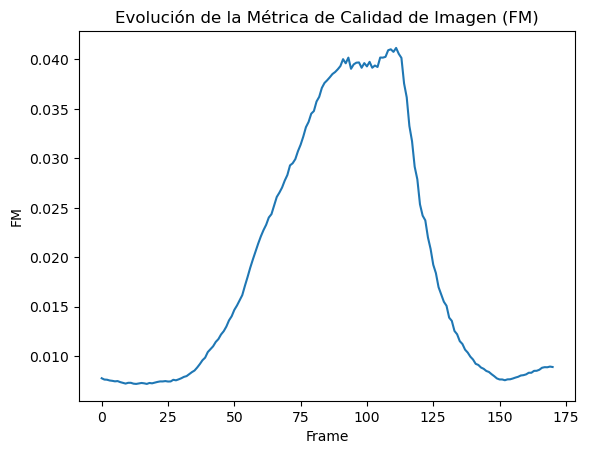

Frame con máximo enfoque: 111


In [155]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Obtén las dimensiones del video
    frame_width = int(captura_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Obtener la cantidad de frames
    frame_count = int(captura_video.get(cv2.CAP_PROP_FRAME_COUNT))
    fm_values = []

    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv2.CAP_PROP_FPS))
    fps = 35
    delay = int(1000 / fps)

    def fourier(image):

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Procesamiento básico: convertir a escala de grises
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Siguiendo los pasos del paper requisitado:

        # Step 1
        fourier = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
        
        # Step 2 
        fourier_shift = np.fft.fftshift(fourier)
    
        # Step 3
        AF = cv2.magnitude(fourier_shift[:,:,0], fourier_shift[:,:,1])

        # Step 4
        M = np.max(AF)

        # Step 5
        thres = M / 1000
        TH = np.sum(AF > thres)

        # Step 6
        FM = TH / (image.shape[0] * image.shape[1])

        # # Display the results
        # print(f"Maximum frequency component (M): {M}")
        # print(f"Threshold (thres): {thres}")
        # print(f"Number of pixels above threshold (TH): {TH}")
        # print(f"Image Quality measure (FM): {FM}")

        return FM

    # Definir el codec y crear el objecto VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec para .mp4
    output_video = cv2.VideoWriter('output_video.mp4', fourcc, fps, (frame_width, frame_height))

    
    #Primer ejecutamos el algoritmo para identificar la medida de calidad de imagen

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Convertir frame para gris
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calcular FM
        fm = fourier(gray_frame)
        
        fm_values.append(fm)
    
    max_focus_frame = np.argmax(fm_values)
    median_focus_fm = np.median(fm_values)

    # Ahora ejecutamos una ves mas para marcar los frames con mejor enfoque
    captura_video = cv2.VideoCapture(video_path)
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Convertir frame para gris
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # frame en color
        color_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Calcular FM
        fm = fourier(gray_frame)

        # Marcar frame con cantidad pasando los parametros
        marked_frame = mark_region(color_frame, frame_width, frame_height, fm, median_focus_fm, 3, 3)
           
        # Escribir el frame en video
        output_video.write(marked_frame)


# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
output_video.release()
cv2.destroyAllWindows()

# Plotar los valores FM
plt.plot(fm_values)
plt.title('Evolución de la Métrica de Calidad de Imagen (FM)')
plt.xlabel('Frame')
plt.ylabel('FM')
plt.show()

# Detectamdo el frame con maximo enfoque
max_focus_frame = np.argmax(fm_values)
print(f'Frame con máximo enfoque: {max_focus_frame}')

### 1 - Como se puede observar arriba, fue implementar la función ```def fourier(image):``` para calcular la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y fue hecho una medición por todo los frames y se presentó una curva donde exibió el punto maximo de enfoque (el 111).

### 2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera 
automática


### Para el ejercicio 2, opté por implementar "Brenner’s focus measure":

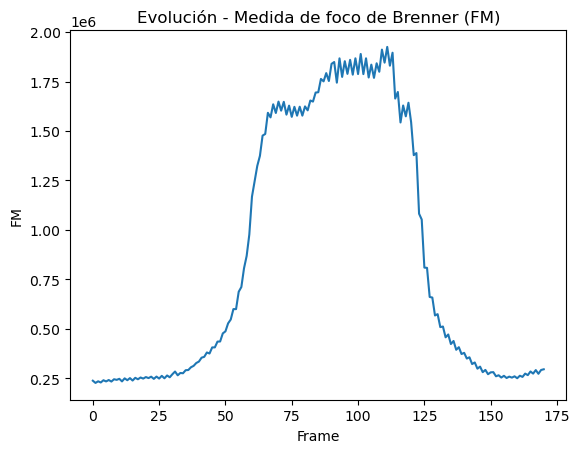

Frame con máximo enfoque utilizando la medida de foco Brenner: 111


In [157]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Obtén las dimensiones del video
    frame_width = int(captura_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Obtener la cantidad de frames
    frame_count = int(captura_video.get(cv2.CAP_PROP_FRAME_COUNT))
    fm_values = []

    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv2.CAP_PROP_FPS))
    fps = 35
    delay = int(1000 / fps)

    def brenner_focus_measure(image):

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Procesamiento básico: convertir a escala de grises
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Siguiendo los pasos del paper requisitado:

        # Calcular la diferencia entre los pixeles horizontales
        diff = np.diff(gray, axis=1)
        
        # Calcular la medida de foco de Brenner
        focus_measure = np.sum(diff[:, :-1] ** 2)
        
        return focus_measure

    # Definir el codec y crear el objecto VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec para .mp4
    output_video = cv2.VideoWriter('output_video.mp4', fourcc, fps, (frame_width, frame_height))

    
    #Primer ejecutamos el algoritmo para identificar la medida de calidad de imagen

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Convertir frame para gris
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calcular FM
        fm = brenner_focus_measure(gray_frame)
        
        fm_values.append(fm)
    
    max_focus_frame = np.argmax(fm_values)
    median_focus_fm = np.median(fm_values)

    # Ahora ejecutamos una ves mas para marcar los frames con mejor enfoque
    captura_video = cv2.VideoCapture(video_path)
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Convertir frame para gris
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # frame en color
        color_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Calcular FM
        fm = brenner_focus_measure(gray_frame)

        # Marcar frame con cantidad pasando los parametros
        marked_frame = mark_region(color_frame, frame_width, frame_height, fm, median_focus_fm, 3, 3)
           
        # Escribir el frame en video
        output_video.write(marked_frame)


# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
output_video.release()
cv2.destroyAllWindows()

# Plotar los valores FM
plt.plot(fm_values)
plt.title('Evolución - Medida de foco de Brenner (FM)')
plt.xlabel('Frame')
plt.ylabel('FM')
plt.show()

# Detectamdo el frame con maximo enfoque
max_focus_frame = np.argmax(fm_values)
print(f'Frame con máximo enfoque utilizando la medida de foco Brenner: {max_focus_frame}')